In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(),"apperception"))

### IMPORTS
import cv2

from world import *
from world_executor import *
from video_util import *
from metadata_util import *
import lens
import point



In [2]:
### Let's define some attribute for constructing the world first
name = 'traffic_scene' # world name
units = 'metrics'      # world units
video_file = os.path.join(os.getcwd(), "amber_videos/traffic-scene-shorter.mp4") #example video file
lens_attrs = {'fov': 120, 
              'cam_origin': (0, 0, 0), 
              'skew_factor': 0}
point_attrs = {'p_id': 'p1', 
               'cam_id': 'cam1', 
               'x': 0,
               'y': 0, 
               'z': 0,
               'time': None, 
               'type':'pos'}
camera_attrs = {'ratio': 0.5}
fps = 30


In [3]:
### First we define a world
traffic_world = World(name=name, units=units)

### Use TASM if it's available on the machine
# traffic_world = World(name=name, units=units, enable_tasm=True)

In [4]:
### Secondly we construct the camera
fov, res, cam_origin, skew_factor = lens_attrs['fov'], [1280, 720], lens_attrs['cam_origin'], lens_attrs['skew_factor']
cam_lens = lens.PinholeLens(res, cam_origin, fov, skew_factor)

pt_id, cam_id, x, y, z, time, pt_type = point_attrs['p_id'], point_attrs['cam_id'], point_attrs['x'], point_attrs['y'], point_attrs['z'], point_attrs['time'], point_attrs['type']
location = point.Point(pt_id, cam_id, x, y, z, time, pt_type)

ratio = camera_attrs['ratio']

In [5]:
### Ingest the camera to the world
traffic_world = traffic_world.camera(cam_id=cam_id, 
                               location=location, 
                               ratio=ratio, 
                               video_file=video_file, 
                               metadata_identifier=name+"_"+cam_id, 
                               lens=cam_lens)

In [6]:
### Call execute on the world to run the detection algorithm and save the real data to the database
recognized_world = traffic_world.recognize(cam_id)
recognized_world.execute()

Worlds Table created successfully........
New world inserted successfully........
Camera Table created successfully........
New camera inserted successfully.........
# of tracked items: 16
Item General Trajectory Table created successfully
General Bboxes Table created successfully........
Item General Trajectory Table created successfully
General Bboxes Table created successfully........
Item General Trajectory Table created successfully
General Bboxes Table created successfully........
Item General Trajectory Table created successfully
General Bboxes Table created successfully........
Item General Trajectory Table created successfully
General Bboxes Table created successfully........
Item General Trajectory Table created successfully
General Bboxes Table created successfully........
Item General Trajectory Table created successfully
General Bboxes Table created successfully........
Item General Trajectory Table created successfully
General Bboxes Table created successfully........
Ite

{'cam1': <video_context.Camera object at 0x7fdb36217c50>}
Module(body=[Return(value=Compare(left=Attribute(value=Name(id='obj', ctx=Load()), attr='object_type', ctx=Load()), ops=[Eq()], comparators=[Str(s='car')]))])
Module(body=[Return(value=Compare(left=Attribute(value=Name(id='obj', ctx=Load()), attr='location', ctx=Load()), ops=[In()], comparators=[Name(id='volume', ctx=Load())]))])
Module(body=[Return(value=Compare(left=Call(func=Name(id='Tmin', ctx=Load()), args=[Attribute(value=Name(id='obj', ctx=Load()), attr='location', ctx=Load())], keywords=[]), ops=[GtE()], comparators=[Name(id='start', ctx=Load())]))])
Module(body=[Return(value=Compare(left=Call(func=Name(id='Tmax', ctx=Load()), args=[Attribute(value=Name(id='obj', ctx=Load()), attr='location', ctx=Load())], keywords=[]), ops=[Lt()], comparators=[Name(id='end', ctx=Load())]))])
Worlds Table created successfully........
New world inserted successfully........
Camera Table created successfully........
New camera inserted suc

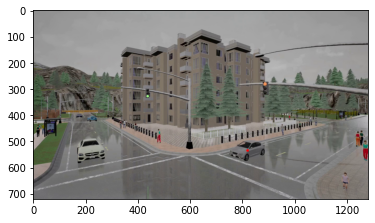

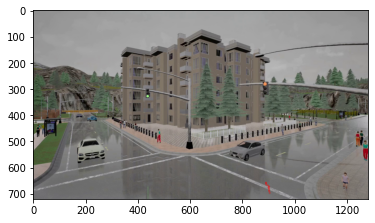

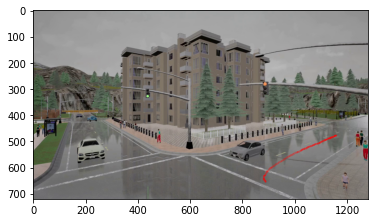

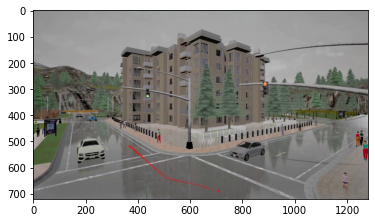

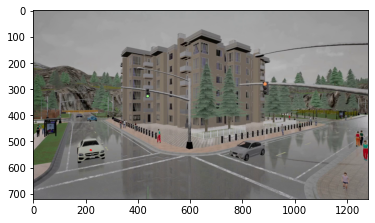

In [7]:
volume = traffic_world.select_intersection_of_interest_or_use_default(cam_id=cam_id)
filtered_world = traffic_world.predicate(lambda obj:obj.object_type == "car").predicate(lambda obj:obj.location in volume, {"volume":volume})
filtered_world = filtered_world.interval([0,fps*4])
 
### to get the trajectory and the video over the entire trajectory(amber case)
filtered_ids = filtered_world.selectkey(distinct = True).execute()
print("filtered_ids are", filtered_ids)
print(len(filtered_ids))
if len(filtered_ids)>0:
    id_array = [e[0] for e in filtered_ids]
    ### Fetch the trajectory of these items
    trajectory = traffic_world.predicate(lambda obj: obj.object_id in id_array, {"id_array":id_array}).get_trajectory(distinct=True).execute()
    traffic_world.overlay_trajectory(cam_id, trajectory)
    ### Get the videos of these items
#     entire_video = traffic_world.predicate(lambda obj: obj.object_id in id_array, {"id_array":id_array}).get_video()
#     entire_video.execute()